In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/customer-personality-analysis/marketing_campaign.csv


# 0. Table of Contents

1. **Data Loading and Initial Exploration**

2. **Data Preprocessing**
    1. Handling Missing Values
    2. One-Hot Encoding of Categorical Variables
    3. Handling Date Columns
    4. Standardizing Numerical Data
    5. Imputation of Missing Values
    6. Converting Integer Columns to Floats

3. **Feature Selection and Correlation Analysis**
    1. Correlation Analysis
    2. PCA Explained Variance Analysis
    3. Determining the Number of Components

4. **K-Means Clustering**
    1. Determining the Optimal Number of Clusters
    2. Applying K-Means Clustering
    3. Visualizing K-Means Clusters


# 1. Data Loading and Initial Exploration

In this step, we begin by loading the marketing campaign dataset into a pandas DataFrame. The dataset is stored in a tab-separated (\t) file format, so we use the appropriate separator when reading the data. After successfully loading the dataset, we proceed to inspect the first few rows to get a general sense of the data's structure and content.

We then explore the dataset's metadata by checking the data types of each column using the info() function. This helps us understand the nature of the features, whether they are numerical or categorical, and provides insight into any potential data cleaning steps that may be required.

Lastly, we check for missing values using isnull().sum(). Identifying missing data early on allows us to decide how to handle incomplete entries, ensuring the integrity of the dataset for further analysis. Based on the results, we can determine whether imputing or removing missing data will be necessary in the next stages.

### Column Descriptions

- **`ID`**: Unique identifier for each customer in the dataset.
- **`Year_Birth`**: The year the customer was born. This can be used to calculate the age of the customer, which is important for demographic analysis.
- **`Education`**: The highest level of education the customer has achieved (e.g., Graduation, PhD). This is a categorical variable that can affect consumer behavior.
- **`Marital_Status`**: The marital status of the customer (e.g., Single, Married, Together). This helps understand household composition and spending habits.
- **`Income`**: The annual income of the customer. Higher income levels may correlate with higher spending on luxury goods.
- **`Kidhome`**: The number of small children (under 12) living in the customer's home. This might influence certain types of purchases, such as toys or food.
- **`Teenhome`**: The number of teenagers (aged 12 to 18) living in the customer's home. Teenagers might impact the type and frequency of purchases.
- **`Dt_Customer`**: The date the customer was enrolled in the company. This can help measure customer loyalty.
- **`Recency`**: The number of days since the customer last made a purchase. This is important for understanding customer engagement.
- **`MntWines`**: The amount of money the customer spent on wine in the last two years.
- **`MntFruits`**: The amount of money the customer spent on fruits in the last two years.
- **`MntMeatProducts`**: The amount of money the customer spent on meat products in the last two years.
- **`MntFishProducts`**: The amount of money the customer spent on fish products in the last two years.
- **`MntSweetProducts`**: The amount of money the customer spent on sweets in the last two years.
- **`MntGoldProds`**: The amount of money the customer spent on gold products in the last two years.
- **`NumDealsPurchases`**: The number of purchases made using a discount or deal.
- **`NumWebPurchases`**: The number of purchases made through the company's website.
- **`NumCatalogPurchases`**: The number of purchases made using a catalog.
- **`NumStorePurchases`**: The number of purchases made in-store.
- **`NumWebVisitsMonth`**: The number of times the customer visited the company's website in the last month.
- **`AcceptedCmp1`, `AcceptedCmp2`, `AcceptedCmp3`, `AcceptedCmp4`, `AcceptedCmp5`**: Binary columns indicating whether the customer accepted marketing campaigns 1 through 5.
- **`Complain`**: Whether the customer has ever filed a complaint with the company (binary: 1 for yes, 0 for no).
- **`Z_CostContact`**: A feature with constant values, possibly related to customer contact cost.
- **`Z_Revenue`**: Another feature with constant values, likely related to revenue estimation.
- **`Response`**: Whether the customer responded positively to the last marketing campaign (binary: 1 for yes, 0 for no).


In [3]:
# Import necessary libraries
import pandas as pd
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
import numpy as np
from sklearn.cluster import KMeans

In [4]:
# Load the dataset
file_path = '/kaggle/input/customer-personality-analysis/marketing_campaign.csv'
data = pd.read_csv(file_path, sep='\t')

In [5]:
# Preview the first few rows of the dataset
data.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,...,5,0,0,0,0,0,0,3,11,0


In [6]:
# Check the structure of the dataset (columns, data types, etc.)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2240 non-null   int64  
 1   Year_Birth           2240 non-null   int64  
 2   Education            2240 non-null   object 
 3   Marital_Status       2240 non-null   object 
 4   Income               2216 non-null   float64
 5   Kidhome              2240 non-null   int64  
 6   Teenhome             2240 non-null   int64  
 7   Dt_Customer          2240 non-null   object 
 8   Recency              2240 non-null   int64  
 9   MntWines             2240 non-null   int64  
 10  MntFruits            2240 non-null   int64  
 11  MntMeatProducts      2240 non-null   int64  
 12  MntFishProducts      2240 non-null   int64  
 13  MntSweetProducts     2240 non-null   int64  
 14  MntGoldProds         2240 non-null   int64  
 15  NumDealsPurchases    2240 non-null   i

In [7]:
# Check for missing values in the dataset
data.isnull().sum()

ID                      0
Year_Birth              0
Education               0
Marital_Status          0
Income                 24
Kidhome                 0
Teenhome                0
Dt_Customer             0
Recency                 0
MntWines                0
MntFruits               0
MntMeatProducts         0
MntFishProducts         0
MntSweetProducts        0
MntGoldProds            0
NumDealsPurchases       0
NumWebPurchases         0
NumCatalogPurchases     0
NumStorePurchases       0
NumWebVisitsMonth       0
AcceptedCmp3            0
AcceptedCmp4            0
AcceptedCmp5            0
AcceptedCmp1            0
AcceptedCmp2            0
Complain                0
Z_CostContact           0
Z_Revenue               0
Response                0
dtype: int64

# 2. Data Preprocessing

In this step, we preprocess the dataset to ensure it is clean and ready for analysis. The preprocessing involves several tasks such as handling missing values, encoding categorical variables, standardizing numerical data, and ensuring consistency in data types.

1. **Handling Missing Values**:
   - First, we remove rows with missing values in the `Income` column, as this feature is critical for analysis. Using the `dropna()` function, we remove any rows that contain a null value in the `Income` column.
   
2. **One-Hot Encoding of Categorical Variables**:
   - We apply one-hot encoding to the `Education` and `Marital_Status` columns to convert categorical data into numerical format. This results in binary columns for each category, and to avoid multicollinearity, we drop the first category using the `drop_first=True` argument.
   
3. **Handling Date Columns**:
   - The `Dt_Customer` column is converted into a `datetime` format using the `pd.to_datetime()` function with `dayfirst=True`. Then, a new feature `Customer_Since` is created to calculate the number of years each customer has been with the company (based on the current year, 2024). After extracting this useful information, the `Dt_Customer` column is dropped.
   
4. **Standardizing Numerical Data**:
   - Numerical columns such as `Income`, `Kidhome`, `Teenhome`, `Recency`, and product spending columns are standardized using the `StandardScaler`. This ensures that all numerical features have a mean of 0 and a standard deviation of 1, making the data more consistent for model training.
   
5. **Imputation of Missing Values**:
   - For any remaining missing values in the numerical columns, we apply mean imputation. This fills in missing values with the column’s mean, ensuring the dataset remains complete and ready for further analysis.

6. **Converting Integer Columns to Floats**:
   - To maintain consistency across all numerical data, we convert all `int32` and `int64` columns to `float64`. This ensures that the dataset has consistent data types across numerical features, which may improve performance and avoid potential issues with certain algorithms.

By the end of this step, the dataset is fully prepared for further analysis or model training. It has been cleaned, standardized, encoded, and missing values have been appropriately handled, ensuring consistency in the data types as well.


In [8]:
# Remove rows with missing values in the 'Income' column
data = data.dropna(subset=['Income'])
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2216 entries, 0 to 2239
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2216 non-null   int64  
 1   Year_Birth           2216 non-null   int64  
 2   Education            2216 non-null   object 
 3   Marital_Status       2216 non-null   object 
 4   Income               2216 non-null   float64
 5   Kidhome              2216 non-null   int64  
 6   Teenhome             2216 non-null   int64  
 7   Dt_Customer          2216 non-null   object 
 8   Recency              2216 non-null   int64  
 9   MntWines             2216 non-null   int64  
 10  MntFruits            2216 non-null   int64  
 11  MntMeatProducts      2216 non-null   int64  
 12  MntFishProducts      2216 non-null   int64  
 13  MntSweetProducts     2216 non-null   int64  
 14  MntGoldProds         2216 non-null   int64  
 15  NumDealsPurchases    2216 non-null   int64 

## 2.2 One-Hot Encoding of Categorical Variables

In [9]:
#One-Hot Encoding for categorical variables
data = pd.get_dummies(data, columns=['Education', 'Marital_Status'], drop_first=True)

## 2.3 Handling Date Columns

In [10]:
# Convert 'Dt_Customer' to datetime and extract useful information
data['Dt_Customer'] = pd.to_datetime(data['Dt_Customer'], dayfirst=True)
data['Customer_Since'] = 2024 - data['Dt_Customer'].dt.year  # Calculate how long they have been a customer

# Optional: Drop the original date column if it's no longer needed
data.drop('Dt_Customer', axis=1, inplace=True)

## 2.4 Standardizing Numerical Data

In [11]:
# Standardize numerical columns (e.g., Income, spending data)
numerical_columns = ['Income', 'Kidhome', 'Teenhome', 'Recency', 'MntWines', 'MntFruits', 
                     'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds',
                     'NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases', 
                     'NumStorePurchases', 'NumWebVisitsMonth']

scaler = StandardScaler()
data[numerical_columns] = scaler.fit_transform(data[numerical_columns])

## 2.5 Imputation of Missing Values

In [12]:
# Fill missing values in the dataset with the mean value of each column
data.fillna(data.mean(), inplace=True)

In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2216 entries, 0 to 2239
Data columns (total 38 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   ID                       2216 non-null   int64  
 1   Year_Birth               2216 non-null   int64  
 2   Income                   2216 non-null   float64
 3   Kidhome                  2216 non-null   float64
 4   Teenhome                 2216 non-null   float64
 5   Recency                  2216 non-null   float64
 6   MntWines                 2216 non-null   float64
 7   MntFruits                2216 non-null   float64
 8   MntMeatProducts          2216 non-null   float64
 9   MntFishProducts          2216 non-null   float64
 10  MntSweetProducts         2216 non-null   float64
 11  MntGoldProds             2216 non-null   float64
 12  NumDealsPurchases        2216 non-null   float64
 13  NumWebPurchases          2216 non-null   float64
 14  NumCatalogPurchases      2216

## 2.6 Converting Integer Columns to Floats

In [14]:
# Convert int32 and int64 columns to float64 for consistency
data = data.astype({col: 'float64' for col in data.select_dtypes(include=['int32', 'int64']).columns})

# Check data types again
data.dtypes

ID                         float64
Year_Birth                 float64
Income                     float64
Kidhome                    float64
Teenhome                   float64
Recency                    float64
MntWines                   float64
MntFruits                  float64
MntMeatProducts            float64
MntFishProducts            float64
MntSweetProducts           float64
MntGoldProds               float64
NumDealsPurchases          float64
NumWebPurchases            float64
NumCatalogPurchases        float64
NumStorePurchases          float64
NumWebVisitsMonth          float64
AcceptedCmp3               float64
AcceptedCmp4               float64
AcceptedCmp5               float64
AcceptedCmp1               float64
AcceptedCmp2               float64
Complain                   float64
Z_CostContact              float64
Z_Revenue                  float64
Response                   float64
Education_Basic               bool
Education_Graduation          bool
Education_Master    

# 3. Feature Selection and Correlation Analysis

## 3.1 Correlation Analysis

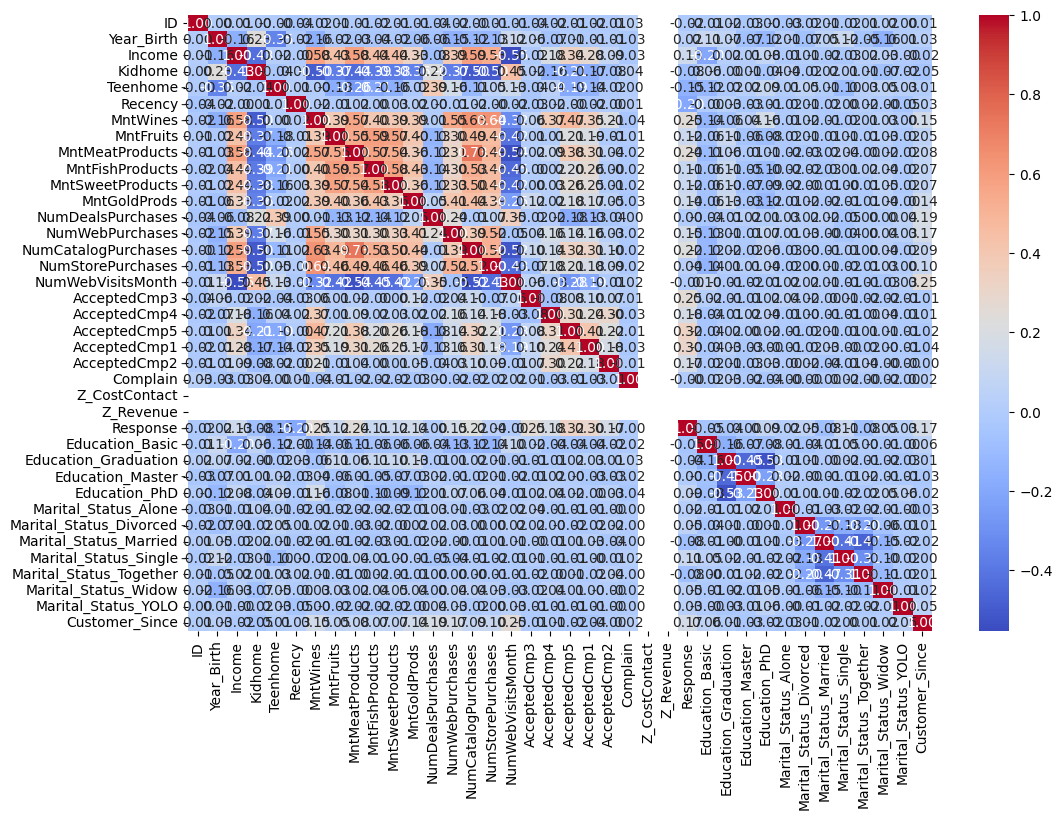

In [15]:
# Calculate the correlation matrix
corr_matrix = data.corr()

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.show()

In [16]:
# Set a correlation threshold (e.g., 0.8)
threshold = 0.8

# Find index pairs where the correlation is above the threshold
high_corr = corr_matrix.abs().unstack().sort_values(ascending=False).drop_duplicates()
high_corr_pairs = high_corr[(high_corr > threshold) & (high_corr < 1)]  # Exclude perfect correlations (1.0)

# Print highly correlated feature pairs
print("Highly correlated pairs (correlation > 0.8):")
print(high_corr_pairs)

Highly correlated pairs (correlation > 0.8):
Series([], dtype: float64)


### Correlation Analysis Results

After performing a correlation analysis with a threshold of 0.8, we found that no pairs of features had a correlation higher than this value. This indicates that the features in the dataset are not highly correlated with each other, and thus, no feature needs to be dropped based on correlation. 

As a result, we will keep all features in the dataset and proceed with the next steps without removing any due to high correlation.


## 3.2 PCA

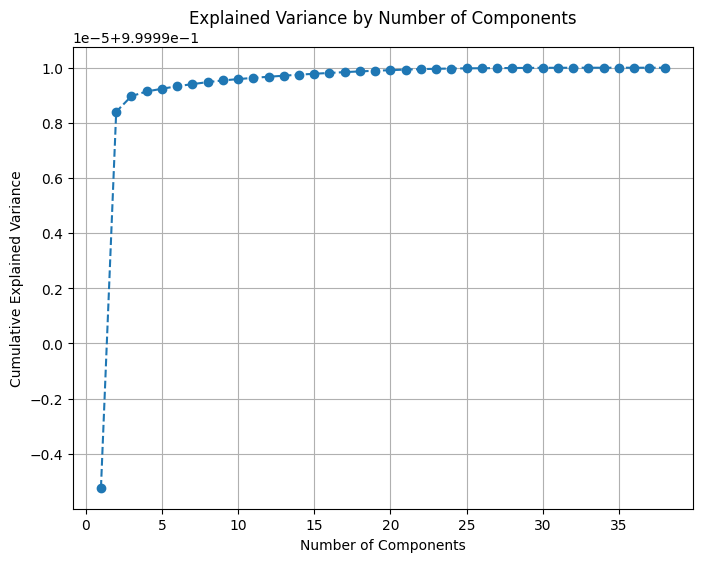

Number of components explaining 90% variance: 1


In [17]:
# Apply PCA to the dataset
# PCA is used to reduce the dimensionality of the data by transforming it into a set of components
# that explain the maximum variance in the data.
pca = PCA()

# Fit PCA to the data and transform it into principal components
# The resulting X_pca contains the transformed data in terms of principal components.
X_pca = pca.fit_transform(data)

# Cumulative explained variance
# This step calculates the cumulative sum of the explained variance ratios for each principal component.
# It shows how much total variance is explained as we include more components.
explained_variance = np.cumsum(pca.explained_variance_ratio_)

# Plot the cumulative explained variance
# The goal of this plot is to visualize how many components are needed to explain a certain percentage of the total variance.
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o', linestyle='--')
plt.xlabel('Number of Components')  # X-axis label showing the number of components
plt.ylabel('Cumulative Explained Variance')  # Y-axis label showing the cumulative explained variance
plt.title('Explained Variance by Number of Components')  # Title of the plot
plt.grid(True)  # Display grid lines on the plot for better readability
plt.show()  # Show the plot

# Determine the number of components that explain at least 90% of the variance
# np.argmax returns the index of the first element where the cumulative explained variance meets or exceeds 90%
# Adding 1 because Python indexing starts at 0 but we want to count the components starting from 1
n_components = np.argmax(explained_variance >= 0.90) + 1
print(f"Number of components explaining 90% variance: {n_components}")

In [18]:
# Example: If you want to choose components explaining 95% variance
n_components_95 = np.argmax(explained_variance >= 0.95) + 1  # Number of components that explain at least 95% variance
print(f"Number of components explaining 95% variance: {n_components_95}")

# Example: If you want to choose components explaining 99% variance
n_components_99 = np.argmax(explained_variance >= 0.99) + 1  # Number of components that explain at least 99% variance
print(f"Number of components explaining 99% variance: {n_components_99}")


Number of components explaining 95% variance: 1
Number of components explaining 99% variance: 1


### PCA Explained Variance Analysis

In this analysis, we applied **Principal Component Analysis (PCA)** to our dataset in order to determine how much variance each component explains. PCA is a dimensionality reduction technique that transforms the data into a set of new features called **principal components**. Each component captures a portion of the overall variance in the data, and the goal is to retain the most important components while reducing the dimensionality.

#### Key Steps:

- **PCA Application**: We applied PCA to the dataset and calculated the **explained variance ratio** for each principal component. This shows the proportion of the dataset's variance that each component explains.
- **Cumulative Explained Variance Plot**: The cumulative explained variance plot allows us to visualize how much total variance is explained as we include more components.
- **Component Selection**: We calculated the number of components that explain **90%**, **95%**, and **99%** of the variance in the dataset.

#### Results:

- **90% Variance Explained**: The number of components required to explain at least **90% of the variance** is **1**.
  - This means that one component is sufficient to capture 90% of the variability in the data.
  
- **95% Variance Explained**: The number of components required to explain at least **95% of the variance** is also **1**.
  - This shows that even if we aim to capture more variance (up to 95%), we still only need one component.

- **99% Variance Explained**: Similarly, for **99% of the variance**, only **1 component** is required.
  - This suggests that the first principal component is very strong, explaining almost all of the variance in the data, while the remaining components are much less informative.

#### Why Do We Use 2 Components Instead of 1?

Even though the analysis shows that a single component explains over **90%** (and even **99%**) of the variance, there are important reasons to consider using **2 components**:

- **More Insight into Data Structure**:
  - While the first component captures most of the variance, it represents only one dimension of the data. By including the second component, we gain a better understanding of the multidimensional structure of the data.
  - This allows us to explore how the data is distributed across multiple axes, which is particularly useful for clustering algorithms like **K-Means**. With more than one component, K-Means can better separate the data into clusters, as it has more dimensions to work with.

- **Better Clustering Performance**:
  - In clustering, especially when using algorithms like **K-Means**, more than one component often leads to better cluster separation. One component may not capture all the important differences between the groups in your data, whereas two or more components can provide enough information to distinguish the clusters more effectively.
  - Using **2 components** helps K-Means find clusters in both dimensions, which is critical for accurate groupings.

- **Avoiding Oversimplification**:
  - While one component captures most of the variance, it might **oversimplify** the data and ignore other potentially meaningful relationships between features. By using two components, we avoid this oversimplification and retain more information about the data's structure.
  - This is especially important when you want to **visualize** the data in 2D, as having two components allows for a more informative plot and clearer insights into the cluster structure.

- **Visualizing the Data**:
  - Using two components allows us to create meaningful **2D scatter plots** that help in visualizing the clusters. With only one component, we would be limited to a single dimension, which would make visual inspection of the clusters difficult.

#### Conclusion:

Even though a single component explains over **90%** of the variance in the dataset, we choose to use **2 components** because:
  
- It gives us more insight into the data's multidimensional structure.
- It improves the performance of clustering algorithms like **K-Means**.
- It avoids **oversimplifying** the data.
- It enables better data **visualization**, especially when plotting clusters in 2D.

Thus, while PCA shows that one component explains most of the variance, using **two components** provides more comprehensive information for analysis and clustering.


# 4.  K-Means Clustering 

## 4.1 Determining the Optimal Number of Clusters

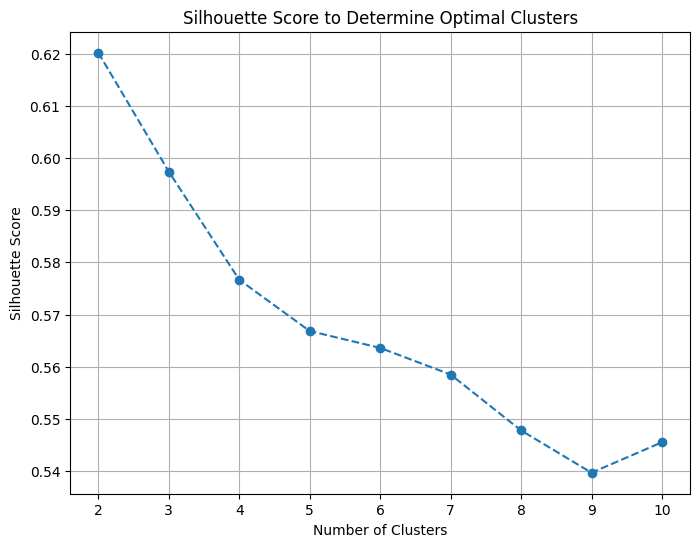

In [19]:
# Create a list to hold the silhouette scores for each number of clusters
silhouette_scores = []

# Run K-Means for cluster numbers from 2 to 10 and calculate silhouette score
for i in range(2, 11):  # Silhouette score cannot be calculated for 1 cluster
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(X_pca)  # Assuming X_pca is your PCA-transformed data
    score = silhouette_score(X_pca, kmeans.labels_)
    silhouette_scores.append(score)

# Plot the silhouette scores to find the optimal cluster number
plt.figure(figsize=(8, 6))
plt.plot(range(2, 11), silhouette_scores, marker='o', linestyle='--')
plt.title('Silhouette Score to Determine Optimal Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.grid(True)
plt.show()

### Silhouette Score Analysis for Determining Optimal Number of Clusters

The **Silhouette Score** measures how similar each point in one cluster is to points in its own cluster compared to points in other clusters. A higher Silhouette Score indicates better-defined clusters, while a lower score suggests that points are overlapping between clusters. The score ranges from -1 to 1, where a score closer to 1 indicates well-separated clusters.

#### Key Observations:

- **Maximum Silhouette Score:** The plot shows that the highest Silhouette Score is achieved with **2 clusters**, with a score of approximately **0.62**. This suggests that the data is best separated into 2 distinct clusters. At this point, the clustering algorithm is able to differentiate well between the two groups, with minimal overlap.
  
- **Score Decreases with More Clusters:** As the number of clusters increases beyond 2, the Silhouette Score steadily decreases. For example:
  - With **3 clusters**, the score drops to approximately **0.60**.
  - At **4 clusters**, the score is around **0.58**, and it continues to drop as the number of clusters increases.
  
  This decline in score indicates that as the number of clusters increases, the data points within the clusters become less cohesive and the distinction between clusters weakens. Essentially, more clusters seem to reduce the clarity of the groupings, making the boundaries between clusters blurrier.

- **Performance at Higher Cluster Counts:** By the time the number of clusters reaches **9 or 10**, the Silhouette Score drops to approximately **0.54**, suggesting that these higher cluster counts are less effective at grouping the data meaningfully. The fact that the score plateaus around 9 and 10 clusters means that adding more clusters is unlikely to provide meaningful improvements in clustering performance.

#### Recommendation:

Based on the Silhouette Score analysis, the optimal number of clusters for this dataset appears to be **2**. This is where the model achieves the highest separation between clusters, and further increasing the number of clusters leads to diminished performance. 

It is recommended to proceed with **2 clusters** for further analysis or any subsequent clustering-based decision-making processes.


## 4.2 Applying K-Means Clustering

In [20]:
# Apply PCA with 2 components
pca = PCA(n_components=2)
X_pca = pca.fit_transform(data)

# Apply K-Means clustering
kmeans = KMeans(n_clusters=2, random_state=42)  # You can change the number of clusters
kmeans.fit(X_pca)

# Add cluster labels to the original data
data['Cluster'] = kmeans.labels_

# Check the results, showing only 'ID' and 'Cluster'
data[['ID', 'Cluster']]

,ID,Cluster
0,5524.0,0
1,2174.0,0
2,4141.0,0
3,6182.0,1
4,5324.0,0
...,...,...
2235,10870.0,1
2236,4001.0,0
2237,7270.0,1
2238,8235.0,1


## 4.3 Visualizing K-Means Clusters

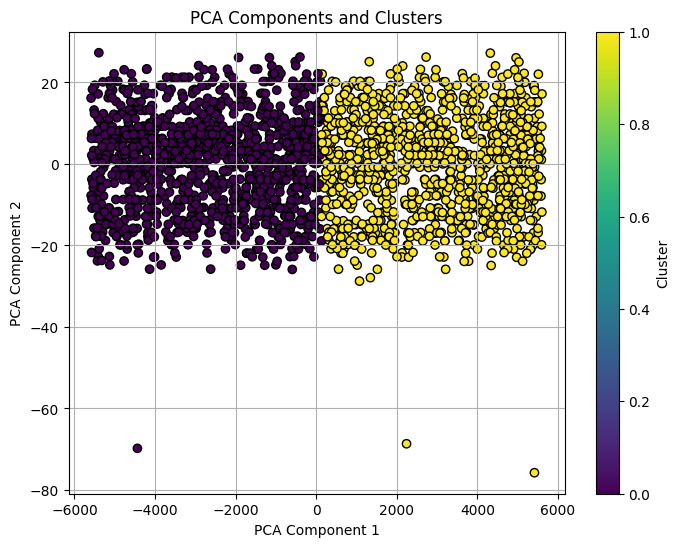

In [21]:
# Plot clusters with the first two components from PCA
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=data['Cluster'], cmap='viridis', marker='o', edgecolor='k')
plt.title('PCA Components and Clusters')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.grid(True)
plt.colorbar(label='Cluster')
plt.show()

### Conclusion:

The analysis successfully grouped the customers into **two clusters**, providing a foundation for potential marketing strategies tailored to these segments. This segmentation can help the business better understand its customer base, allowing for targeted marketing campaigns and personalized engagement strategies. By utilizing **PCA** for dimensionality reduction and **K-Means** for clustering, we were able to identify meaningful patterns in customer behavior, which can be further explored to maximize business outcomes.
